### Simple MLP 7 b

Testing new infimnist on every epoch

RMSProp solver with DropOut

1000 x 500 

1500 epochs

see:  https://github.com/nlintz/TensorFlow-Tutorials/blob/master/4_modern_net.py



In [1]:
# A Multilayer Perceptron implementation example using TensorFlow library.
# This example is using the MNIST database of handwritten digits
# (http://yann.lecun.com/exdb/mnist/)=


# Author: Aymeric Damien
# Project: https://github.com/aymericdamien/TensorFlow-Examples/

In [2]:
import tensorflow as tf
import numpy as np
import input_data

In [15]:
import os
from subprocess import Popen
INFIMNIST = '/Users/charlesmartin/packages/infimnist/infimnist -d /Users/charlesmartin/packages/infimnist/data '

class InfiMNIST(object):

    def __init__(self):
        self.data_dir = "."
        self._infimnist_start = 10000
        self._infimnist_stop =  self._infimnist_start + 59999

    def next_epoch(self):
        #print "creating infimnist pat files %d - %d" % (self._infimnist_start, self._infimnist_stop)
        lab_file = os.path.join(self.data_dir, 'infimnist-labels')
        pat_file = os.path.join(self.data_dir, 'infimnist-images')
        
        # execute cmd 
        
        with open(lab_file, 'wb') as out:
            cmd = "{} lab {} {} ".format(INFIMNIST, self._infimnist_start, self._infimnist_stop)
            #print cmd
            Popen(cmd, shell=True, stdout=out, cwd=self.data_dir).wait()
            
        with open(pat_file, 'wb') as out:
            cmd = "{} pat {} {} ".format(INFIMNIST, self._infimnist_start, self._infimnist_stop)
            #print cmd
            Popen(cmd, shell=True, stdout=out, cwd=self.data_dir).wait()
        
        cmd1 = "rm infimnist-labels.gz infimnist-images.gz mnist-labels.gz mnist-images.gz"
        cmd2 = "gzip -f infimnist-labels infimnist-images"
        cmd3 = "ln -s infimnist-labels.gz  mnist-labels.gz"
        cmd4 = "ln -s infimnist-images.gz  mnist-images.gz"

        os.system(cmd1)
        os.system(cmd2)
        os.system(cmd3)
        os.system(cmd4)
        
        self._infimnist_start = self._infimnist_stop + 1
        self._infimnist_stop =  self._infimnist_start + 59999


In [16]:
infiminst = InfiMNIST()

In [17]:
# Parameters
learning_rate = 0.001
training_epochs = 1500
batch_size = 100
display_step = 1
total_batch = 55000/100

In [18]:
# Network Parameters
n_hidden_1 = 1000 # 1st layer num features
n_hidden_2 = 500 # 2nd layer num features
n_input = 784 # MNIST data input (img shape: 28*28)
n_classes = 10 # MNIST total classes (0-9 digits)

std_0 = 1.0/np.sqrt(n_input)
std_h1 = 1.0/np.sqrt(n_hidden_1)
std_h2 = 1.0/np.sqrt(n_hidden_2)


In [19]:
# tf Graph input
x = tf.placeholder("float", [None, n_input])
y = tf.placeholder("float", [None, n_classes])

In [20]:
# dropout parameters
pv = tf.placeholder("float")
ph = tf.placeholder("float")

In [21]:
def multilayer_perceptron(_X, _weights, _biases, _pv, _ph):

    _Xd = tf.nn.dropout(_X, _pv)
    
    layer_1 = tf.nn.relu(tf.add(tf.matmul(_Xd, _weights['h1']), _biases['b1'])) 
    layer_1d =  tf.nn.dropout(layer_1, _ph)
    
    layer_2 = tf.nn.relu(tf.add(tf.matmul(layer_1d, _weights['h2']), _biases['b2'])) 
    layer_2d =  tf.nn.dropout(layer_2, _ph)

    
    return tf.matmul(layer_2d, weights['out']) + biases['out']

In [22]:
# Store layers weight & bias
weights = {
    'h1': tf.Variable(tf.random_normal([n_input, n_hidden_1], stddev=std_0)),
    'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2], stddev=std_h1)),
    'out': tf.Variable(tf.random_normal([n_hidden_2, n_classes], stddev=std_h2))
}
biases = {
    'b1': tf.Variable(tf.random_normal([n_hidden_1], stddev=std_h1)),
    'b2': tf.Variable(tf.random_normal([n_hidden_2], stddev=std_h2)),
    'out': tf.Variable(tf.random_normal([n_classes], stddev=0.3))
}


In [23]:
# Construct model
pred = multilayer_perceptron(x, weights, biases, pv, ph )

In [24]:
# Define loss and optimizer
# Softmax loss
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(pred, y)) 

optimizer = tf.train.RMSPropOptimizer(learning_rate=learning_rate).minimize(cost) 

In [25]:
# Initializing the variables
init = tf.initialize_all_variables()

In [26]:
# Launch the graph
import input_data

accs = []
with tf.Session() as sess:
    sess.run(init)

    # Training cycle
    for epoch in range(training_epochs):
        infiminst.next_epoch()
        mnist = input_data.read_data_sets(".", one_hot=True)
        avg_cost = 0.0
        # Loop over all batches
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)
            # Fit training using batch data
            sess.run(optimizer, feed_dict={x: batch_xs, y: batch_ys, pv: 0.8, ph: 0.5})
            # Compute average loss
            avg_cost += sess.run(cost, feed_dict={x: batch_xs, y: batch_ys, pv: 1.0, ph: 1.0})/total_batch
            
        # Display logs per epoch step
        if epoch % display_step == 0:
            print "Epoch:", '%04d' % (epoch+1), "cost=", "{:.9f}".format(avg_cost)
            correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
            accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
            a = accuracy.eval(feed_dict={x: mnist.test.images, y: mnist.test.labels, pv:1.0, ph:1.0})
            accs.append(a)
            print "Accuracy:", a

    # Test model
    correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
    # Calculate accuracy
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    print "Accuracy:", accuracy.eval({x: mnist.test.images, y: mnist.test.labels, pv:1.0, ph:1.0})

//anaconda/lib/python2.7/gzip.py:275: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  chunk = self.extrabuf[offset: offset + size]
input_data.py:35: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  data = data.reshape(num_images, rows, cols, 1)


Epoch: 0001 cost= 0.516851781
Accuracy: 0.94
Epoch: 0002 cost= 0.107424831
Accuracy: 0.9632
Epoch: 0003 cost= 0.064063173
Accuracy: 0.9664
Epoch: 0004 cost= 0.052800251
Accuracy: 0.9741
Epoch: 0005 cost= 0.049693898
Accuracy: 0.9701
Epoch: 0006 cost= 0.046786212
Accuracy: 0.9747
Epoch: 0007 cost= 0.049327933
Accuracy: 0.9768
Epoch: 0008 cost= 0.047461787
Accuracy: 0.9761
Epoch: 0009 cost= 0.050009991
Accuracy: 0.9789
Epoch: 0010 cost= 0.047020487
Accuracy: 0.9799
Epoch: 0011 cost= 0.049886919
Accuracy: 0.9808
Epoch: 0012 cost= 0.052703238
Accuracy: 0.9789
Epoch: 0013 cost= 0.054061225
Accuracy: 0.9789
Epoch: 0014 cost= 0.053154383
Accuracy: 0.98
Epoch: 0015 cost= 0.052553646
Accuracy: 0.9814
Epoch: 0016 cost= 0.054089898
Accuracy: 0.9796
Epoch: 0017 cost= 0.052466951
Accuracy: 0.9798
Epoch: 0018 cost= 0.052365250
Accuracy: 0.9789
Epoch: 0019 cost= 0.052321715
Accuracy: 0.9782
Epoch: 0020 cost= 0.054628617
Accuracy: 0.9814
Epoch: 0021 cost= 0.053389601
Accuracy: 0.9795
Epoch: 0022 cost=

KeyboardInterrupt: 

In [27]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  

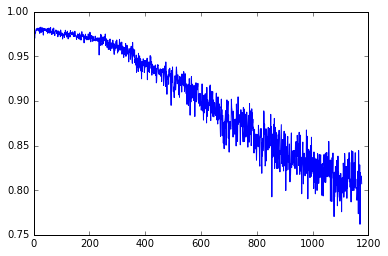

In [28]:
plt.plot(accs)
